# Design Pattern 4 - MultiModal Input  (Chapter 2)

## Introduction to Design Pattern

The idea of MultiModal input is to give a model multiple types of input to help performance. For example, for an image recognition model to identify traffic violations we would also want our model to have some metadata (time of day, day of week, ...) to validate the violation. 

This idea of having multiple inputs of different types, lets us add more useful information to our models. 

## Example python implementation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Embedding, Input, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model


In [2]:
tf.__version__

'2.4.1'

## Combining text and tabular inputs

To demonstrate this we'll use a toy example dataset of restaurant reviews, defined below. For demo purposes, we've only defined the training dataset here.

This model attemps to take a text review, the meal type and total meal cost to predict the number of starts on the review. 

In [3]:
reviews_data = {
    "review_text": ["The food was great, but it took forever to get seated.", "The tacos were life changing.",
                    "This food made me question the presence of my taste buds."],
    "meal_type": ["lunch", "dinner", "dinner"],
    "meal_total": [50, 75, 60],
    "rating": [4, 5, 1]
}

Step 1: process `review_text` so it can be fed in as an embedding

* recall previous Design Pattern on Embedding 

In [4]:
vocab_size = 50
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenize.fit_on_texts(reviews_data['review_text'])

reviews_train = tokenize.texts_to_sequences(reviews_data['review_text'])
max_sequence_len = 20
reviews_train = keras.preprocessing.sequence.pad_sequences(reviews_train, maxlen=max_sequence_len, padding='post')

print(reviews_train)

[[ 1  2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0]
 [ 1 12 13 14 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [16  2 17 18 19  1 20 21 22 23 24  0  0  0  0  0  0  0  0  0]]


Step 2: convert `meal_type` to a one-hot encoding 

In [5]:
reviews_data['meal_type'] # meal types

['lunch', 'dinner', 'dinner']

In [6]:
possible_meal_vocab = ['breakfast', 'lunch', 'dinner']
one_hot_meals = []

for i in reviews_data['meal_type']:
  one_hot_arr = [0] * len(possible_meal_vocab)
  one_index = possible_meal_vocab.index(i)
  one_hot_arr[one_index] = 1
  one_hot_meals.append(one_hot_arr)

In [7]:
one_hot_meals

[[0, 1, 0], [0, 0, 1], [0, 0, 1]]

Step 3: combine one-hot `meal_type` with `meal_total` into a single array 

In [8]:
reviews_data['meal_total'] # meal totals

[50, 75, 60]

In [9]:
tabular_features = np.concatenate((np.array(one_hot_meals), np.expand_dims(reviews_data['meal_total'], axis=1)), axis=1)

In [10]:
tabular_features

array([[ 0,  1,  0, 50],
       [ 0,  0,  1, 75],
       [ 0,  0,  1, 60]])

Step 4: build the tabular and embedding layers with the Keras functional API

In [11]:
batch_size = len(reviews_data['review_text'])

embedding_input = Input(shape=(max_sequence_len,))
embedding_layer = Embedding(batch_size, 64)(embedding_input)
embedding_layer = Flatten()(embedding_layer)
embedding_layer = Dense(3, activation='relu')(embedding_layer)

tabular_input = Input(shape=(len(tabular_features[0]),))
tabular_layer = Dense(32, activation='relu')(tabular_input)

2022-08-04 16:25:58.243715: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-04 16:25:58.244480: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-04 16:25:58.247351: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Step 5: concatenate the layers into a model

In [12]:
merged_input = keras.layers.concatenate([embedding_layer, tabular_layer])
merged_dense = Dense(16)(merged_input)
output = Dense(1)(merged_dense)

model = Model(inputs=[embedding_input, tabular_input], outputs=output)

In [13]:
# Preview the model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 64)       192         input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1280)         0           embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
______________________________________________________________________________________________

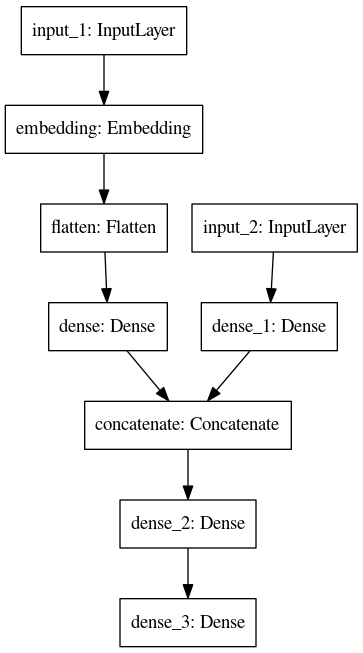

In [14]:
plot_model(model)

So here we have created a model that takes two types of input, a text embedding and a tabular input. 

# Real world weather example!

This model was designed by Charlie Kirkwood, UoE PhD student, published in this paper: [Bayesian Deep Learning for Spatial Interpolation in the Presence of Auxiliary Information](https://link.springer.com/article/10.1007/s11004-021-09988-0)

The model takes two different inputs/ layers (MultiModal!) 

1. A 2D input, in this elevation 
    * This side of the model is convolutional, containing 4 layers
    
2. A 1D input, containing auxilary information (latitude, longitute, elevation, sin_of_hour, cos_of_hour) 
    * This side has dense layers 
    
The idea behind this model is to take site specific information from the crowd sourced [WOW stations](https://wow.metoffice.gov.uk/) along with elevation to spatially interpolate, in this case temperature. Each 2D input is centred on one of these sites. The 1D auxillary information contains the sites latitude, longitute, elevation and i included the sin and cos of the hour of the day, since this model was trained over a 24hr period. 

Diagram of the model from Charlies paper:

<img src="Images/CK_model_diagram.webp">


Plot showing the disbrobution of sites in my dataset, plotted over elevation: 

<img src="Images/distribution_wow_stations.png" width=400>

Importing packages used for this code, some stuff is repeated 

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Activation
from tensorflow.keras.layers import Dropout, SpatialDropout2D, AveragePooling2D, concatenate, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import r2_score

import os
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import iris 
import iris.plot as iplt
import iris.quickplot as qplt

print(tf.__version__)

tfd = tfp.distributions
tfpl = tfp.layers

2.4.1


Step 1: Setting up the model 

In [16]:
filter_size=128 
kernel_size=(3,3) 
stride_size=[3,1,1,1]
dilation_rate=1
dropout_rate=0.2
spatial_dropout_rate=0.5


conv_input = tf.keras.Input(shape = (32,32,1),name= 'conv_input')    

# Create building block layers
# Conv block 1
conv_layer_1 = Conv2D(filters=filter_size,
                           kernel_size=kernel_size,
                           strides=stride_size[0],
                           dilation_rate = dilation_rate, name='conv_1')(conv_input)
activation_layer_1 = Activation('relu', name='relu_act_1')(conv_layer_1)
spatial_dropout_layer_1 = SpatialDropout2D(rate = spatial_dropout_rate,
                                                    name='spatial_dropout_1')(activation_layer_1)

# Conv block 2
conv_layer_2 = Conv2D(filters=filter_size,
               kernel_size=kernel_size,
               strides=stride_size[1],
               dilation_rate = dilation_rate, name='conv_2')(spatial_dropout_layer_1)
activation_layer_2 = Activation('relu', name='relu_act_2')(conv_layer_2)
spatial_dropout_layer_2 = SpatialDropout2D(rate = spatial_dropout_rate,
                                                       name='spatial_dropout_2')(activation_layer_2)

# Conv block 3
conv_layer_3 = Conv2D(filters=filter_size,
               kernel_size=kernel_size,
               strides=stride_size[2],
               dilation_rate = dilation_rate, name='conv_3')(spatial_dropout_layer_2)
activation_layer_3 = Activation('relu', name='relu_act_3')(conv_layer_3)
spatial_dropout_layer_3 = SpatialDropout2D(rate = spatial_dropout_rate,
                                                       name='spatial_dropout_3')(activation_layer_3)

# Conv block 4
conv_layer_4 = Conv2D(filters=filter_size,
               kernel_size=kernel_size,
               strides=stride_size[3],
               dilation_rate = dilation_rate, name='conv_4')(spatial_dropout_layer_3)
activation_layer_4 = Activation('relu', name='relu_act_4')(conv_layer_4)
spatial_dropout_layer_4 = SpatialDropout2D(rate = spatial_dropout_rate,
                                                       name='spatial_dropout_4')(activation_layer_4)

# Conv Pool and Flatten
conv_pool_layer = AveragePooling2D(pool_size = (3,3), strides = (1,1),
                                       name='conv_pool')(spatial_dropout_layer_4)
conv_flatten_layer = Flatten(name='conv_flatten')(conv_pool_layer)

conv_output = conv_flatten_layer

#### aux stuff
aux_input = tf.keras.Input(shape = (5),name= 'aux_input')
# Aux layers
aux_dense_layer = Dense(512, name='aux_dense')(aux_input) # this one 512 before but its 1920 in the paper
aux_activation_layer = Activation('relu', name='aux_relu_act')(aux_dense_layer)
aux_dropout_layer = Dropout(rate = dropout_rate, name='aux_dropout')(aux_activation_layer)
aux_flatten_layer = Flatten(name='aux_flatten')(aux_dropout_layer)

aux_output = aux_flatten_layer

main_input = concatenate([conv_output, aux_output])
# Main model layers
main_dense_1 = Dense(256, name = 'main_dense_1')(main_input)
main_activation_1 = Activation('relu', name = 'main_relu_act_1')(main_dense_1)
main_dropout_1 = Dropout(rate = dropout_rate, name = 'main_dropout_1')(main_activation_1)

main_dense_2 = Dense(128, name = 'main_dense_2')(main_dropout_1)
main_activation_2 = Activation('relu', name = 'main_relu_act_2')(main_dense_2)
main_dropout_2 = Dropout(rate = dropout_rate, name = 'main_dropout_2')(main_activation_2)

main_dense_3 = Dense(2,activation = 'linear', name = 'main_dense_4')(main_dropout_2)


main_final_dist = tfpl.DistributionLambda(make_distribution_fn=lambda t: tfd.Normal(loc = t[..., 0],
                                                   scale = (1e-3 + tf.math.softplus(0.1 * t[..., 1]))),
                                               name='output_dist')(main_dense_3)
main_output = main_final_dist


model = Model(inputs = [conv_input, aux_input], outputs = main_output)

opt = Adam(learning_rate = 0.001, decay = 1e-6)

Define the loss function 

In [17]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

Compile the model 

In [18]:
model.compile(loss=nll,
              optimizer=opt)

2022-08-04 16:26:01.188357: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


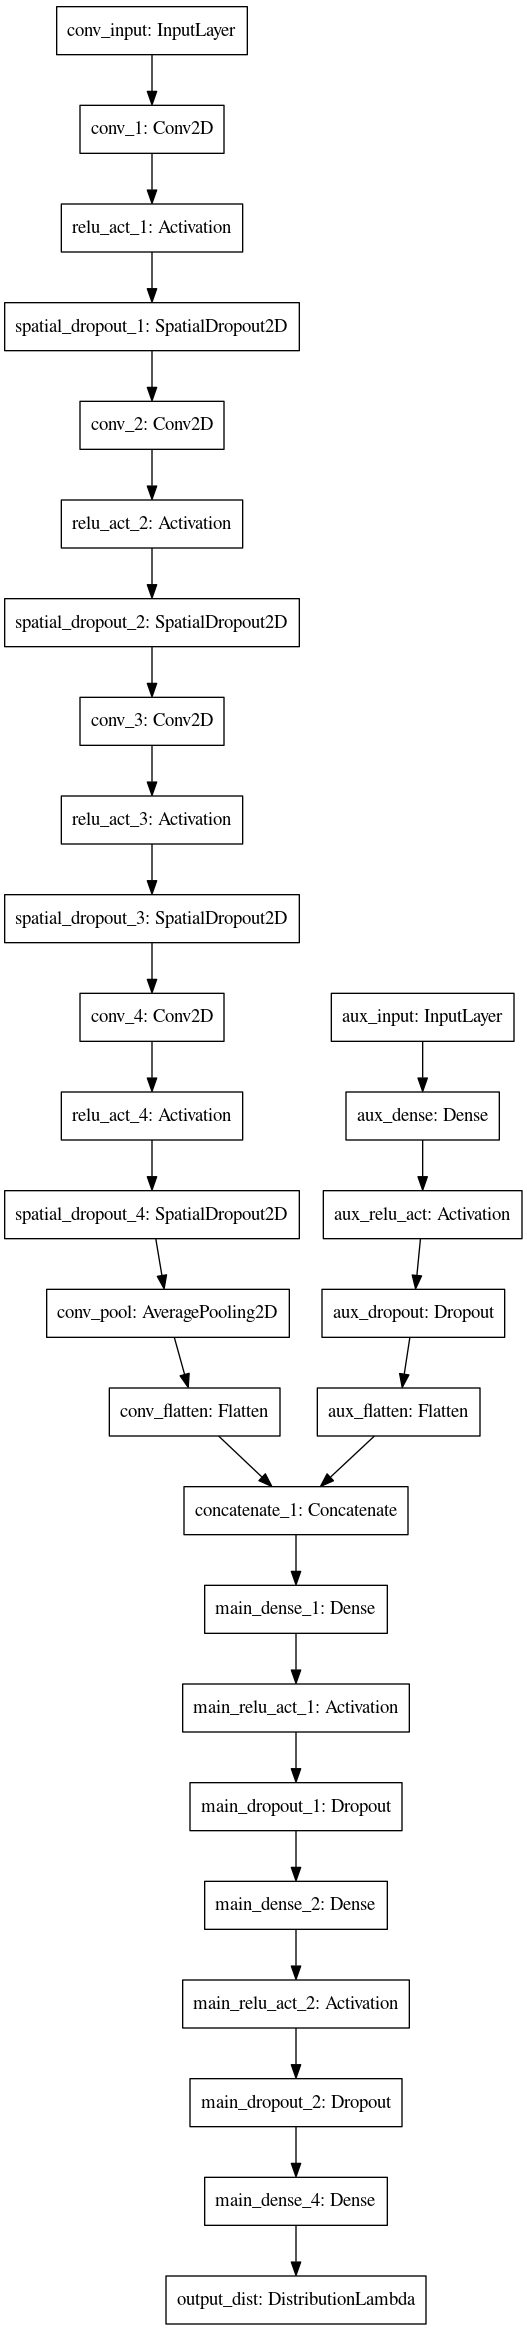

In [19]:
plot_model(model)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv_input (InputLayer)         [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 10, 10, 128)  1280        conv_input[0][0]                 
__________________________________________________________________________________________________
relu_act_1 (Activation)         (None, 10, 10, 128)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
spatial_dropout_1 (SpatialDropo (None, 10, 10, 128)  0           relu_act_1[0][0]                 
____________________________________________________________________________________________

Step 2: Load in and prep data 

* define a function for extracting region


In [21]:
def extract_region(cube,lat_min,lat_max,lon_min,lon_max):
    return cube.intersection(longitude=(lon_min,lon_max),latitude=(lat_min,lat_max))

In [22]:
# need to cut down our cube 
lon_max = 1.8
lon_min = -8
lat_max = 59
lat_min = 50

# load in cube and get required 24 hr period 
temp_file = '/project/spice/informatics_lab/data_science_cop/design_patterns_samples/dp4_multimodel_input/ukv_hourly_no_regrid_t1o5m_london_2018.nc'
temp_cube = iris.load_cube(temp_file)
temp_cube = temp_cube[24:48,:,:]
# extract the UK 
temp_cube = extract_region(temp_cube,lat_min,lat_max,lon_min,lon_max)
# will need this later to normalise
temp_mean = temp_cube.collapsed(['time','latitude','longitude'],iris.analysis.MEAN).data
temp_std = temp_cube.collapsed(['time','latitude','longitude'],iris.analysis.STD_DEV).data

/home/h06/ncreaser/.conda/envs/Tensorflow/lib/python3.7/site-packages/iris/cube.py:3523: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/h06/ncreaser/.conda/envs/Tensorflow/lib/python3.7/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda/envs/Tensorflow/lib/python3.7/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'forecast_period'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda/envs/Tensorflow/lib/python3.7/site-packages/iris/coords.py:1982: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/home/h06/ncreaser/.conda/envs/Tensorflow/lib/python3.7/site-packages/iris/coords

I extract the full uk first as i need the mean and standard deviation as this is how the training data was normalised 

In [23]:
# i have no idea why i saved lat/lon indexs to do this but oh well 
# extract a smaller cut out of the uk to save on computation
# load in our data to use
lat_indexs = np.load('/project/spice/informatics_lab/data_science_cop/design_patterns_samples/dp4_multimodel_input/lat_indexs.npy')
lon_indexs = np.load('/project/spice/informatics_lab/data_science_cop/design_patterns_samples/dp4_multimodel_input/lon_indexs.npy')
temp_cube = temp_cube[:,lat_indexs,:]
temp_cube = temp_cube[:,:,lon_indexs]

# get the shape of the cut down cube 
shape = temp_cube[0].shape

<img src="Images/cutout_region.png" width=300>

Load in pre prepared 2d and 1d inputs 

In [24]:
conv_input = np.load('/project/spice/informatics_lab/data_science_cop/design_patterns_samples/dp4_multimodel_input/conv_input_test_region.npy')
aux_input = np.load('/project/spice/informatics_lab/data_science_cop/design_patterns_samples/dp4_multimodel_input/aux_input_test_region.npy')

In [25]:
conv_input.shape

(103885, 32, 32, 1)

In [26]:
aux_input.shape # this is by 3 as we will add hour later 

(103885, 3)

Extracting lat, lon and elev from the loaded file to then stack with sin_hour, cos_hour 

In [27]:
lats = aux_input[:,0]
lons = aux_input[:,1]
elev = aux_input[:,2]

Create an array of ones the same size aux input  for the hours 

In [28]:
ones = np.ones(aux_input.shape[0])

Select an hour of the day, i'm gonna pick 15

In [29]:
hour = 15

In [30]:
def sin_cos(hour):
    sin  = np.sin((hour/23)*np.pi)
    cos  = np.cos((hour/23)*np.pi)
    return sin,cos

In [31]:
sin, cos = sin_cos(hour)
sins = ones * sin
coss = ones * cos

stack lat, lon, elev, sin_hour, cos_hour to create the aux input then convert to tensor 

In [32]:
aux_input = np.stack((lats,lons,elev,sins,coss),axis=1)

In [33]:
conv_input = tf.convert_to_tensor(conv_input,dtype=tf.float32)
aux_input = tf.convert_to_tensor(aux_input,dtype=tf.float32)

Step 3: Load model weights and run stuff!

In [34]:
model.load_weights('/project/spice/informatics_lab/data_science_cop/design_patterns_samples/dp4_multimodel_input/kirkwood_model_day_bs1')

put both inputs into the array and run through the model 

In [35]:
model_input = [conv_input,aux_input]

output = model(model_input)

This is a bayesian model so we learn a distribution at the end, therefore we can get a mean and standard deviation prediction for each point

In [36]:
means = output.mean()
std = output.stddev()

Get all the 'True' values (however true UKV is) and normalise (remember we calculated the mean and standard deviation earlier)

In [37]:
def normalise(point,mean,std):
    point = (point - mean) / std
    return point

In [38]:
y_input = temp_cube[hour][::-1].data
y_input = normalise(y_input,temp_mean,temp_std)

print the R2 score, note the output from the model is flipped compared to the y_input, `[::-1]` simply flips the array 

In [40]:
r2 = r2_score(y_input.ravel(),means.numpy()[::-1].ravel())
print('r2 score for region at hour {} = {}'.format(hour,r2))

r2 score for region at hour 15 = 0.5073512058037981


Plot the distributions of the true values compared to our model 

Plot the region maps of the truth, our model output and the standard deviation 

In [41]:
def plot_dist(true_values,model_values,hour):
    sns.set_style('whitegrid')

    sns.kdeplot(true_values, bw=0.5,label='True values')
    sns.kdeplot(model_values,bw=0.5,label='Model values')
    plt.legend()

    plt.title('Distributions for 02/01/2018 {}:00 '.format(hour))
    
def plot_region(true_values,model_values,std_dev_model,shape,hour):
    plt.figure(figsize=(12,8))
    plt.suptitle('Maps for 02/01/2018 {}:00 '.format(hour))
    model_values = np.reshape(model_values,shape)
    plt.subplot(1,3,1)
    plt.title('True values')
    plt.pcolormesh(true_values)
    plt.clim(-4,2)
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.title('Model values')
    plt.pcolormesh(model_values[::-1])
    plt.clim(-4,2)
    plt.colorbar()

    plt.subplot(1,3,3)
    std_dev_model = np.reshape(std_dev_model,shape)
    plt.title('Model standard deviation')
    plt.pcolormesh(std_dev_model[::-1])
    plt.clim(0,0.4)
    plt.colorbar()

/home/h06/ncreaser/.conda/envs/Tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/h06/ncreaser/.conda/envs/Tensorflow/lib/python3.7/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


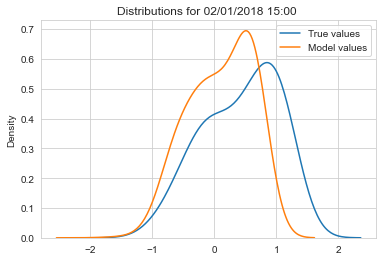

In [42]:
plot_dist(y_input.ravel(),means.numpy().ravel(),hour)

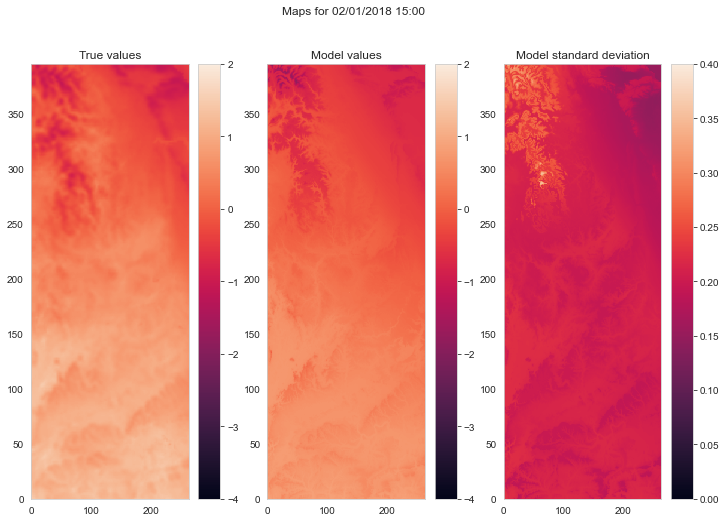

In [44]:
plot_region(y_input,means.numpy(),std.numpy(),shape,hour)